# Cauchy Distribution
***
## Definition
>The Cauchy distribution (sometimes called Lorentz distribution) [...] is the distribution of the ratio of two independent normally distributed random variables if the denominator distribution has mean zero.$ ^{[1]}$.

## Formula
The probability density function of a Cauchy distributed random variable is defined as:
$$ f(x;x_0, \lambda) = \frac{1}{\pi \lambda} \big[\frac{\lambda^2}{(x-x_0)^2 + \lambda^2} \big]$$

with 

$x_0$: location parameter - denotes where the peak of the distribution is 

$\lambda$: scaling parameter - streches the distribution 

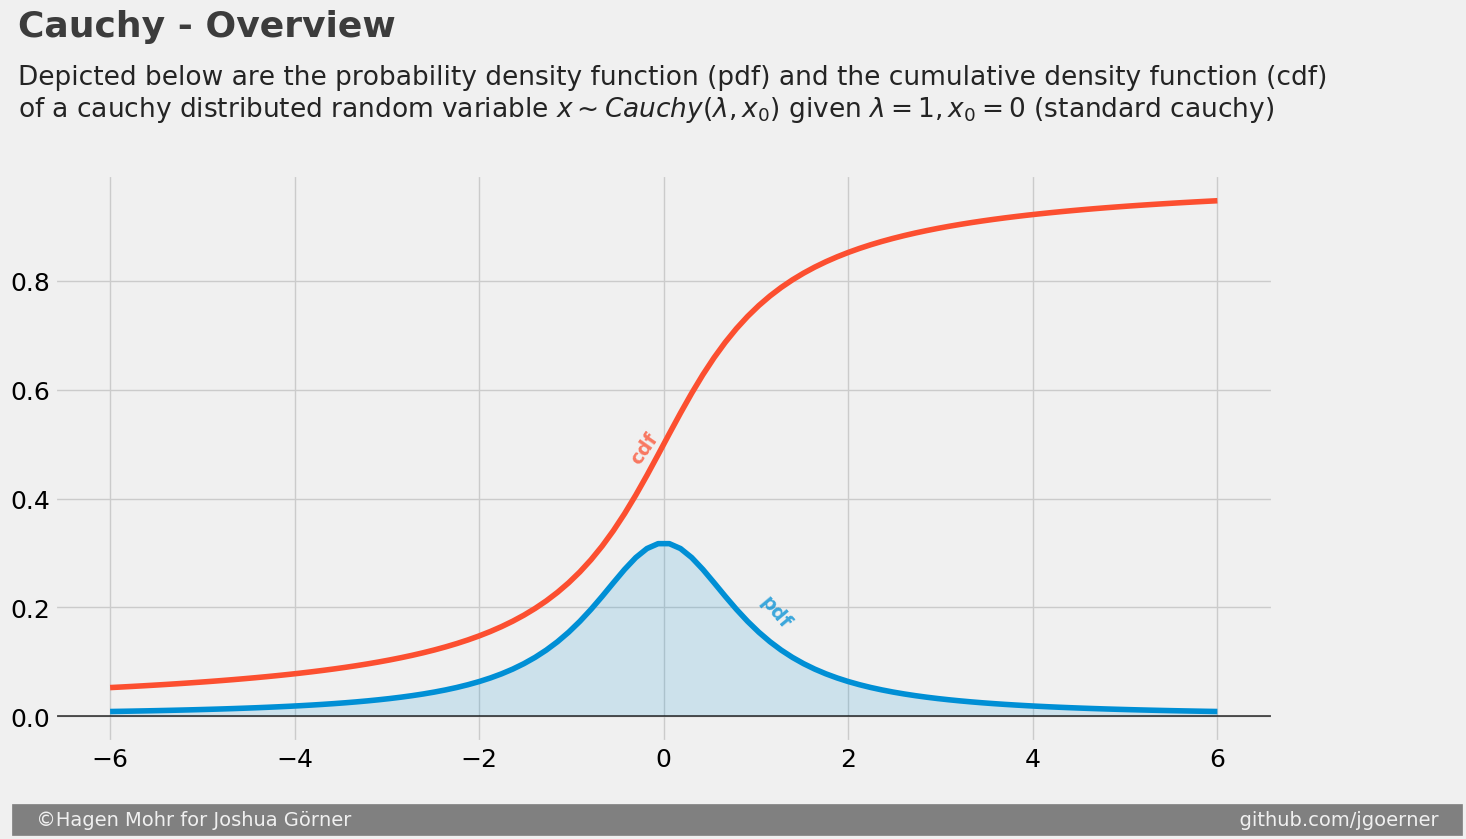

In [8]:
# %load ../src/cauchy/01_general.py

***
## Parameters

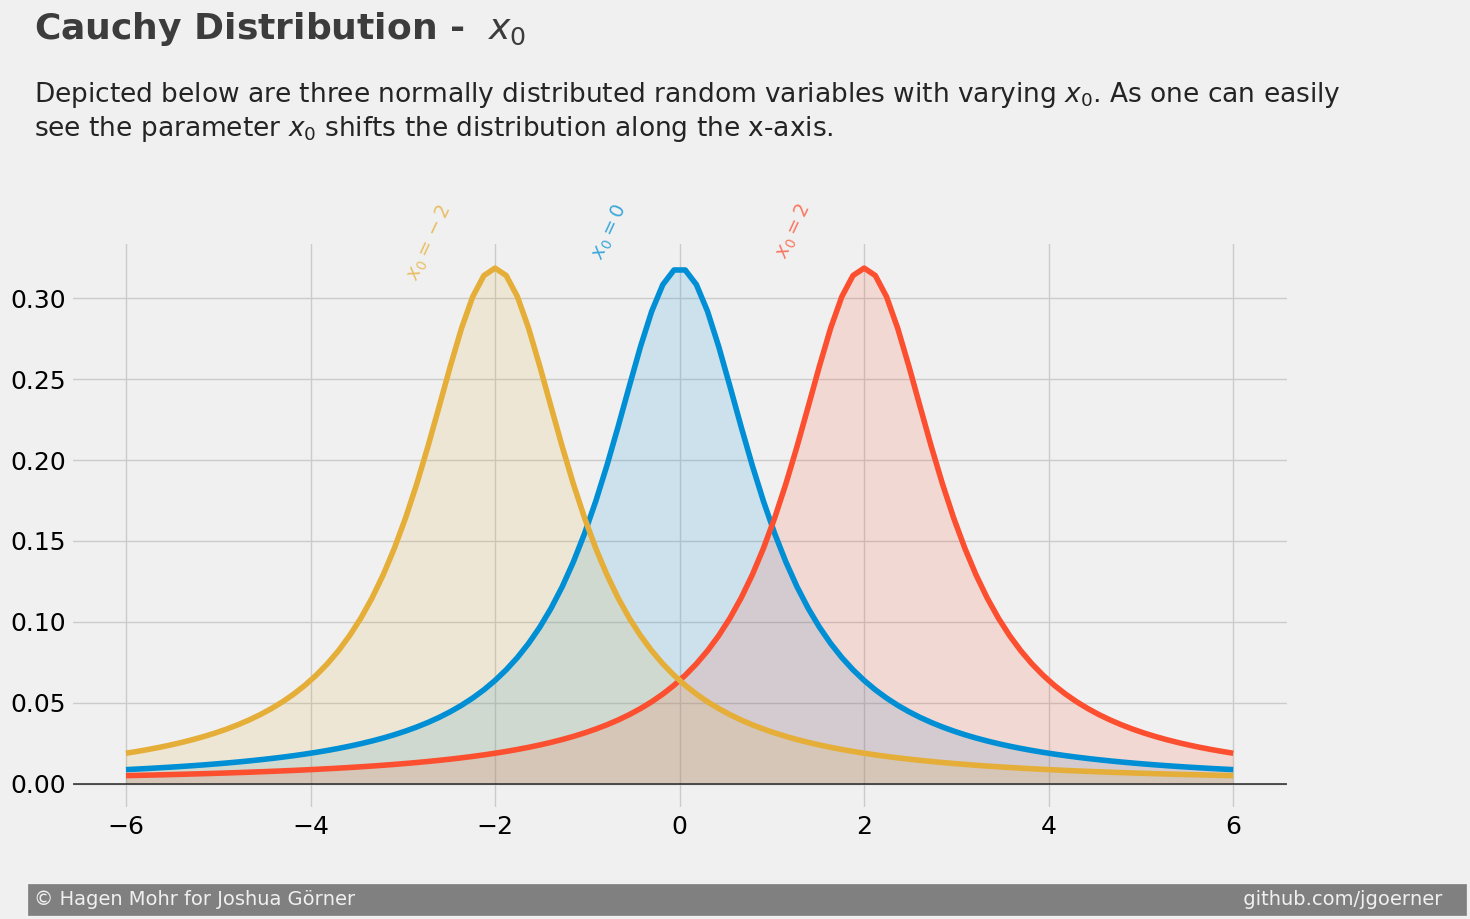

In [9]:
# %load ../src/cauchy/02_x_0.py

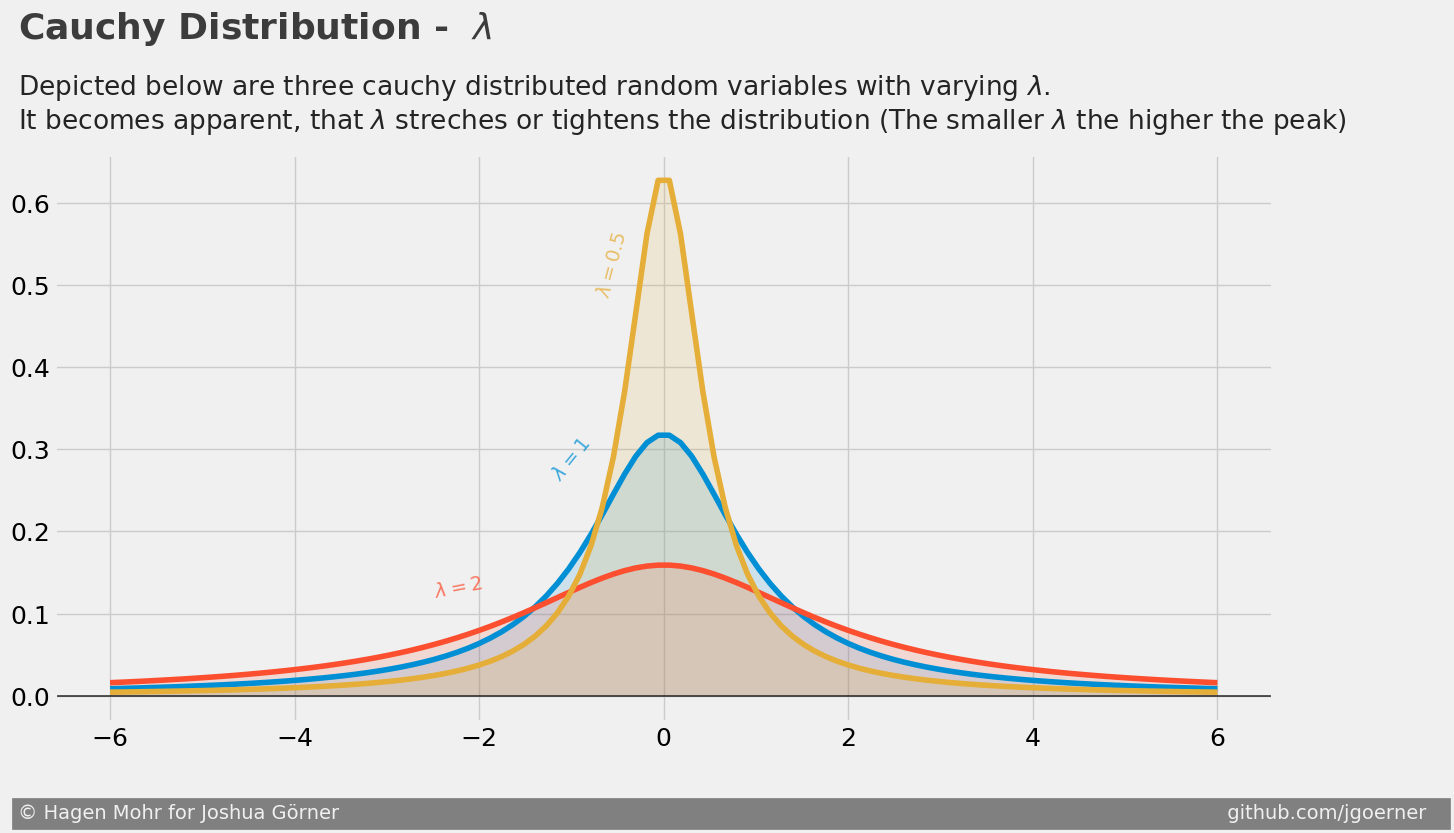

In [10]:
# %load ../src/cauchy/03_lambda.py

*** 
## Implementation in Python
Multiple Python packages implement the Cauchy distribution. One of those is the `stats.cauchy` module from the `scipy` package. The following methods are only an excerpt. For a full list of features the [official documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cauchy.html) should be read.

### Random Variates
In order to generate a random sample from, the function `rvs` should be used. It is parameterized by the location parameter
the scale and the size (# of samples to be drawn)

In [11]:
import numpy as np
from scipy.stats import cauchy

# draw a single sample from the standard cauchy
np.random.seed(42)
print(cauchy.rvs(loc=0, scale=1, size=1), end="\n\n")


# draw 10 samples from a shifted and streched cauchy
print(cauchy.rvs(loc=2, scale=3, size=10), end="\n\n")

[-0.41590722]

[ 21.2203089    4.67844061   2.96079982  -3.62243123  -3.62345717
 -14.25772246   8.71026182   2.98639055   4.29807886 -44.32604102]



### Probability Density Function
The probability mass function can be accessed via the `pdf` function  Like the `rvs` method, the `pdf` allows for adjusting the location and scale of the random variable:

pdf(X=1) = 0.15915494309189535
pdf(X=7) = 0.006366197723675814


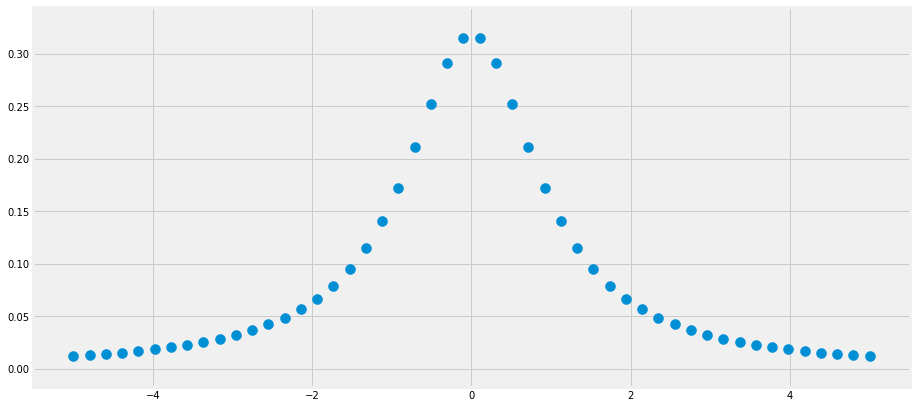

In [12]:
from scipy.stats import cauchy

# additional imports for plotting purpose
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,7)

# likelihood of x and y
x = 1
y = 7
print("pdf(X=1) = {}\npdf(X=7) = {}".format(cauchy.pdf(x=x, loc=0, scale=1), cauchy.pdf(x=y, loc=0, scale=1)))

# continuous pdf for the plot
x_s = np.linspace(-5, 5, 50)
y_s = cauchy.pdf(x=x_s, loc=0, scale=1)
plt.scatter(x_s, y_s, s=100);

### Cumulative Probability Density Function
The cumulative probability density function is useful when a probability range has to be calculated. It can be accessed via the `cdf` function:

In [13]:
from scipy.stats import cauchy

# probability of x less or equal 0.3
print("P(X <=3) = {}".format(cauchy.cdf(x=3, loc=0, scale=1)))

# probability of x in [-2, +2]
print("P(-2 < X <= 2) = {}".format(cauchy.cdf(x=2, scale=1, loc=0) - cauchy.cdf(x=-2, scale=1, loc=0)))

P(X <=3) = 0.8975836176504333
P(-2 < X <= 2) = 0.7048327646991335


***
## Infering $\lambda$ and/or $x_0$
Given a sample of datapoints it is often required to estimate the "true" parameters of the distribution. It is important to note, that the moments of the cauchy distribution (mean, variance, skewness, kurtosis) are __not defined__. $x_0$ is __not__ the mean of the function. 

$x_0$ denotes the mode (=median) of the distribution.

There are multiple ways to infer the scale parameter. Here are three examples$ ^{[2]}$:
1. Quick estimate: A reasonable quick estimate for $\lambda$ can be obtained from half the interquartile range. The median absolute value would be a corresponding quantity for $x_0 = 0$.
2. MLE:  Let X be $\sim Cauchy(\lambda, x_0)$ for known $x_0$. The MLE is given by: 
$\sum\limits_{i} \frac{\lambda^2}{(x_i - x_0)^2 + \lambda^2} = \frac{n}{2}$
3. Efficient one-step-estimation: Based on the Hodges-Lehman estimator and a given $x_0 = 0$ the following equation produces an efficient estimate:
$log(\lambda_h) = \frac{1}{2} med(ln(|X_i X_j|), 1 \leq i, j \leq n, i \leq j$


## Infering $\lambda$ and $x_0$ - MCMC
In addition to a "direct" inference, $\lambda$ can also be estimated using Markov chain Monte Carlo simulation - implemented in Python's [PyMC3](https://github.com/pymc-devs/pymc3).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████| 100500/100500 [00:48<00:00, 2059.90it/s]


95% of sampled x_0s are between 9.515 and 10.196
95% of sampled lambdas are between 1.340 and 2.002


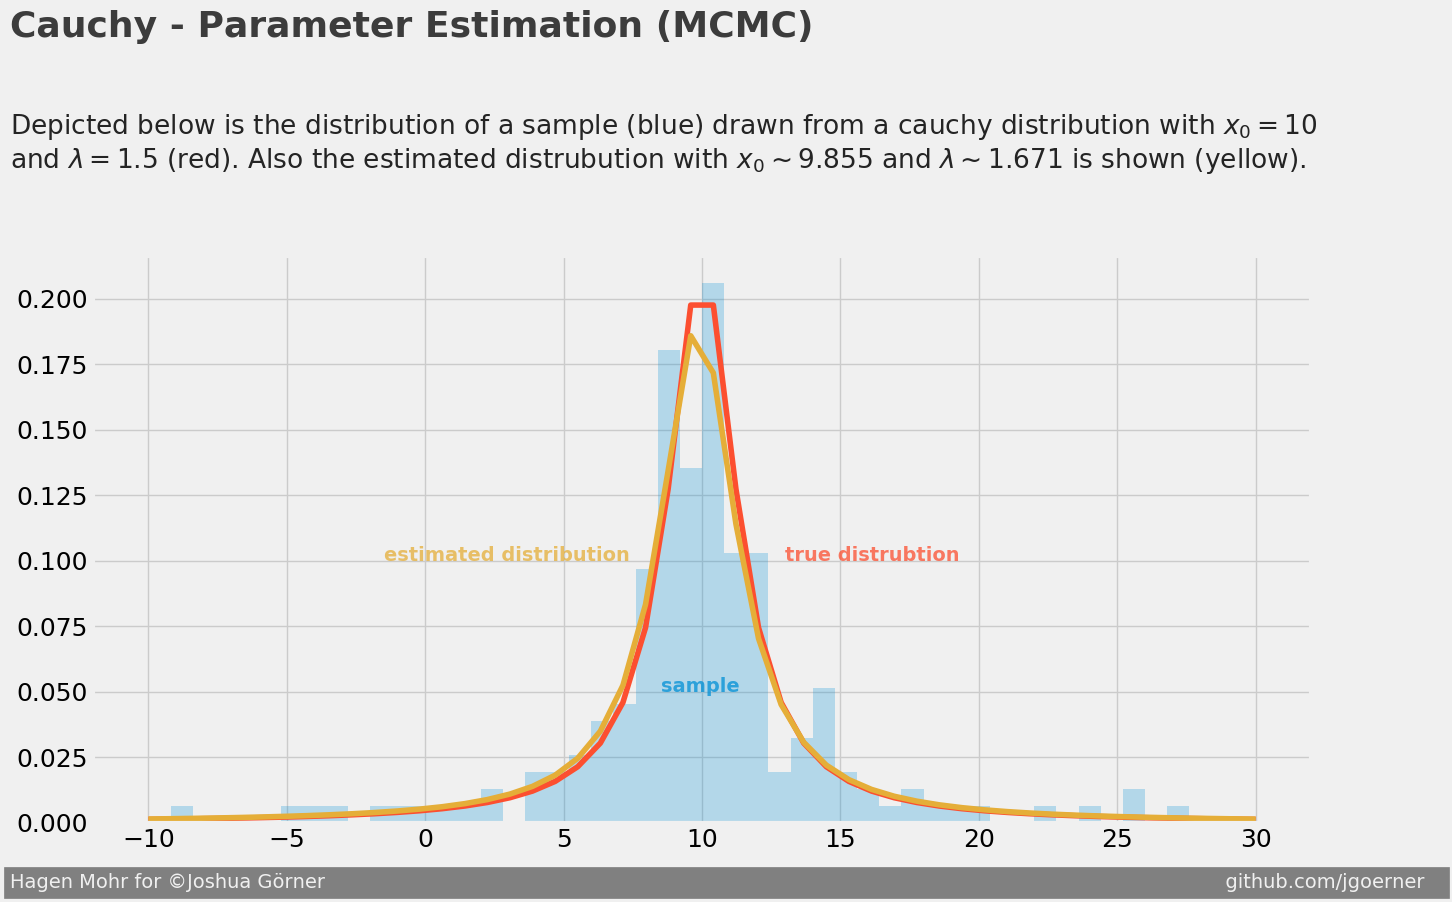

In [18]:
# %load ../src/cauchy/04_mcmc_estimation.py
# IMPORTS
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.style as style
from IPython.core.display import HTML

# PLOTTING CONFIG
%matplotlib inline
style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (14, 7)
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
}
</style>
""")
plt.figure(dpi=100)

##### GENERATE DATA #####
x_0_true = 10
lambd_true = 1.5
np.random.seed(42)
sample = stats.cauchy.rvs(loc=x_0_true, scale=lambd_true, size=200)

##### SIMULATION #####
# MODEL BUILDING
with pm.Model() as model:
    x_0 = pm.Uniform("x_0", upper=50) # technically x_0 could take on negative values - not tested here
    lambd = pm.Uniform("lambda", upper=20) # lambda is always > 0
    cauchy = pm.Cauchy("cauchy", alpha=x_0, beta=lambd, observed=sample)

# MODEL RUN
with model:
    trace = pm.sample(draws=100000)
    burned_trace = trace[20000:]

# x_0 - 95% CONF INTERVAL
x_0s = burned_trace["x_0"]
x_0_est_95 = np.mean(x_0s) - 2*np.std(x_0s), np.mean(x_0s) + 2*np.std(x_0s)
print("95% of sampled x_0s are between {:0.3f} and {:0.3f}".format(*x_0_est_95))

# Lambda - 95% CONF INTERVAL
lambds = burned_trace["lambda"]
lambd_est_95 = np.mean(lambds) - 2*np.std(lambds), np.mean(lambds) + 2*np.std(lambds)
print("95% of sampled lambdas are between {:0.3f} and {:0.3f}".format(*lambd_est_95))

#### PLOTTING #####
# SAMPLE DISTRIBUTION
plt.hist(sample, bins=50,normed=True, alpha=.25, range=[-10, 30])

# TRUE CURVE
plt.plot(np.linspace(-10, 30, 50), stats.cauchy.pdf(np.linspace(-10, 30, 50),loc=x_0_true, scale=lambd_true))

# ESTIMATED CURVE MCMC
plt.plot(np.linspace(-10, 30, 50), stats.cauchy.pdf(np.linspace(-10, 30, 50),loc=np.mean(x_0s), scale=np.mean(lambds)))

# LEGEND
plt.text(x=8.5, y=.05, s="sample", alpha=.75, weight="bold", color="#008fd5")
plt.text(x=13, y=.1, s="true distrubtion", rotation=0, alpha=.75, weight="bold", color="#fc4f30")
plt.text(x=-1.5, y=.1, s="estimated distribution", rotation=0, alpha=.75, weight="bold", color="#e5ae38")

# TICKS
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

# TITLE, SUBTITLE & FOOTER
plt.text(x = -15, y = 0.3, s = "Cauchy - Parameter Estimation (MCMC)",
               fontsize = 26, weight = 'bold', alpha = .75)
plt.text(x = -15, y = 0.25,
         s = 'Depicted below is the distribution of a sample (blue) drawn from a cauchy distribution with ' + r'$x_0 = 10$' + '\nand ' + r'$\lambda = 1.5$ (red). ' + r'Also the estimated distrubution with $x_0 \sim {:.3f} $ and $\lambda \sim {:.3f} $ is shown (yellow).'.format(np.mean(x_0s), np.mean(lambds)),
         fontsize = 19, alpha = .85)
plt.text(x = -15,y = -0.025,
         s = 'Hagen Mohr for ©Joshua Görner                                                                                                                                                   github.com/jgoerner   ',
         fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey');


***
[1] - [Wikipedia. Cauchy Distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)

[2] - [Stackexchange - How to calculate Cauchy scale parameter](https://stats.stackexchange.com/questions/105934/how-to-calculate-the-scale-parameter-of-a-cauchy-random-variable)